In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
from matplotlib import style
from pathlib import Path  
style.use('ggplot') or plt.style.use('ggplot')


In [2]:
# Read in the data: This is the ds/dt field at the ice base 

data = pd.read_csv('../Simulations/DerwaelSimulations/n3E0.2dsdtAdjustment/dsdtOutputTime20.csv', sep=",")


,dsdt,smb,Points:0,Points:1,Points:2
0,0.000000e+00,0.30556,961180.0,1895000.0,-321.57
1,-1.136900e-13,0.32071,962880.0,1895000.0,-310.12
2,0.000000e+00,0.41561,968830.0,1895000.0,-309.69
3,0.000000e+00,0.45383,970970.0,1895000.0,-265.33
4,0.000000e+00,0.48820,973460.0,1895000.0,-313.45
...,...,...,...,...,...
10367,1.279600e-07,0.66262,978010.0,1938200.0,-312.40
10368,1.895500e-07,0.54420,977360.0,1939700.0,-307.59
10369,4.426900e-08,0.71693,978440.0,1938300.0,-308.90
10370,1.687900e-07,0.59579,977820.0,1939800.0,-310.83


In [3]:
# Make columns to store the thickness change and BMB

data['ThicknessChange'] = [0] * len(data)
data['BMB'] = [0.85] * len(data)
data['BMBnew'] = [0] * len(data)


In [4]:
# Calculate the thickness change at each point

data['ThicknessChange'] = - data['dsdt'] * (10/9)

# Adjust BMB by ds/dt

data['BMBnew'] = data['smb'] - data['ThicknessChange']

# Force all negative values to zero

for i in range(len(data)):
    if data['BMBnew'][i] < 0:
        data['BMBnew'][i] = 0.0


In [5]:
# Interpolate the data

# Find min and max coords

x_min = min(data["Points:0"])
y_min = min(data["Points:1"])
x_max = max(data["Points:0"])
y_max = max(data["Points:1"])
nxy = 1000

# Define structured domain

x = np.linspace(x_min, x_max, nxy)
y = np.linspace(y_min, y_max, nxy)
grid_x, grid_y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]

BMB_new = scipy.interpolate.griddata((data["Points:0"], data["Points:1"]), data["BMBnew"], (grid_x, grid_y), method='linear')


In [6]:

# Apply a Gaussian filter

def Gauss(param, data):
    
    sigma_x = param
    sigma_y = param

    sigma = [sigma_x, sigma_y]
    return sp.ndimage.gaussian_filter(data, sigma)



In [7]:
# Apply different smoothings

Gauss1 = Gauss(1.0, BMB_new)
Gauss5 = Gauss(5.0, BMB_new)
Gauss10 = Gauss(10.0, BMB_new)
Gauss20 = Gauss(20.0, BMB_new)
Gauss50 = Gauss(50.0, BMB_new)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_13604/3298607381.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(CS)


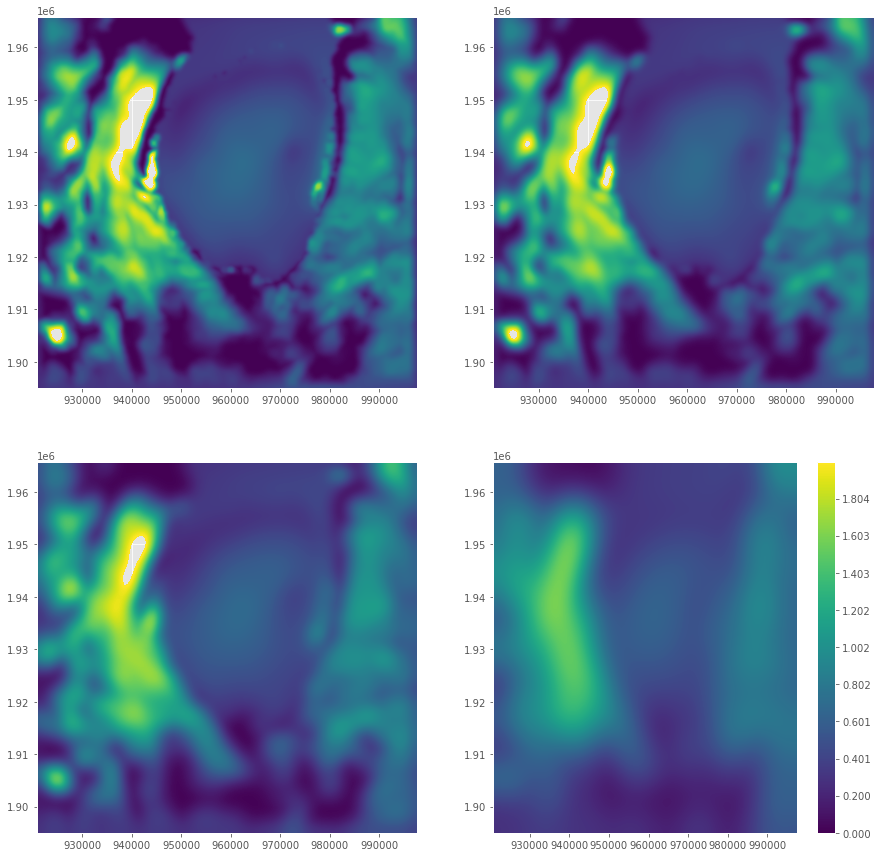

In [8]:
fig, ax = plt.subplots(2,2, figsize=(15, 15))
CS = ax[0][0].contourf(grid_x, grid_y, Gauss5, levels=np.linspace(0.0,2.0,500))
CS = ax[0][1].contourf(grid_x, grid_y, Gauss10, levels=np.linspace(0.0,2.0,500))
CS = ax[1][0].contourf(grid_x, grid_y, Gauss20, levels=np.linspace(0.0,2.0,500))
CS = ax[1][1].contourf(grid_x, grid_y, Gauss50, levels=np.linspace(0.0,2.0,500))

fig.colorbar(CS)


In [9]:
# Convert the desired file to a netcdf file
# Choose Gauss20

da_Gauss20 = xr.DataArray(
    data=Gauss20,
    dims=['y', 'x'],
    coords=dict(
        x=x,
        y=y
    )
)

da_Gauss20.to_netcdf('BMB_new.nc')
da_Gauss20.close()
